In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.interpolate import interp1d
import matplotlib.colors as colors
from itertools import product
from tqdm import tqdm

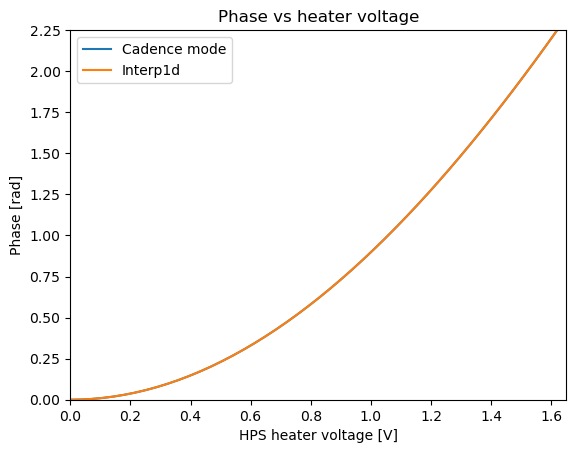

In [2]:
filename = 'phase_x_vheater.csv'
data = np.genfromtxt(filename, delimiter=',', skip_header=1)
vheat = data[:, 0]
phase = data[:, 1] / 180 * np.pi * 2 # add extra factor of 2 to double the range
vheat2phase = interp1d(vheat, phase, kind='linear', fill_value='extrapolate')


voltage_range = np.linspace(0,1.75,101)
phase_range = vheat2phase(voltage_range)

plt.plot(vheat, phase/np.pi,label='Cadence mode')
plt.plot(voltage_range, phase_range/np.pi, label='Interp1d')
plt.legend()
plt.xlim([0, 1.65])
plt.ylim([0, 2.25])
plt.xlabel('HPS heater voltage [V]')
plt.ylabel('Phase [rad]')
plt.title('Phase vs heater voltage')
plt.show()


In [3]:
# DAC specs
dacres = 13
vmax = 1.65
vmin = 0.15

# IADC specs
adcres = 9
iref = 1.25

In [4]:
# Algorithm settings
nstages = 2
state = 1 #state = 0 for 0, state = 1 for pi
dcode = 2 * int(np.pi *vmax / 128 / np.pi * (2**dacres) / (vmax - vmin))
code_update = 0
update_mode = 1.2
fclk = 16e3 
print(f'dcode = {dcode}')
mu1_unscaled = np.logspace(-1, 1, 20)
mu2_unscaled = np.logspace(-2, 0, 20)

dcode = 140


In [5]:
# Sweep settings
slope = 100 # rad/s
u_ind = 2

In [6]:
mu1N = mu1_unscaled.size
mu2N = mu2_unscaled.size
dims = int(80000 * 10/slope)
maxloss = np.zeros((mu1N, mu2N))

phi_u = np.zeros((3, dims))
time = np.arange(0, dims / fclk, 1/fclk)
phi_u[u_ind, ] = slope * time

max_maxloss = -100 

In [7]:
for mu1_ind, mu2_ind in tqdm(product(range(mu1N), range(mu2N)), total=mu1N*mu2N):
    mu1 = mu1_unscaled * (vmax / np.pi * (2**dacres) / (vmax - vmin) / 2**adcres)
    mu2 = mu2_unscaled

    input_te_pow = np.ones(dims)
    input_te_angle = np.zeros(dims)
    input_tm_pow = np.zeros(dims)
    input_tm_angle = np.zeros(dims)

    input_te = input_te_pow * (np.cos(input_te_angle) + np.sin(input_te_angle) * 1j)
    input_tm = input_tm_pow * (np.cos(input_tm_angle) + np.sin(input_tm_angle) * 1j)

    code_ctrl = 0 * np.ones((nstages, dims))
    code_ps = 0 * np.ones((2, nstages, dims))
    voltage_ps = 0 * np.ones((2, nstages, dims))
    phi_ps = 0 * np.ones((2, nstages, dims)) # (upper/lower branch ps, stage, time)

    uout_te = np.zeros((3, dims), dtype=complex)
    uout_tm = np.zeros((3, dims), dtype=complex)

    psout_up = np.zeros((nstages, dims), dtype=complex)
    psout_down = np.zeros((nstages, dims), dtype=complex)
    dcoupout_up = np.zeros((nstages, dims), dtype=complex)
    dcoupout_down = np.zeros((nstages, dims), dtype=complex)

    det_up = np.zeros(dims)
    det_down = np.zeros(dims)
    min_det = np.zeros(dims)
    max_det = np.zeros(dims)
    iadc_code = np.zeros(dims)

    for ind in range(dims):
        for snum in range(nstages):
            if state % 2 == 1:
                code_ctrl[snum, ind] = code_ctrl[snum, ind - 2]
            else:
                code_ctrl[snum, ind] = code_ctrl[snum, ind - 1]

        if state == 1:
            code_ctrl[nstages - 1, ind] = np.minimum(2**dacres - dcode, np.maximum(code_ctrl[nstages - 1, ind-2] + code_update, -2**dacres))
        elif state % 2 == 0:
            code_ctrl[state // 2 - 1, ind] = code_ctrl[state // 2 - 1, ind-1] + dcode
        else:
            code_ctrl[state // 2 - 1, ind] = np.minimum(2**dacres - dcode, np.maximum(code_ctrl[state // 2 - 1, ind-2] + code_update, -2**dacres))
    
        # u1 rotation
        uout_te[0, ind] = input_te[ind] * np.exp(-1j * phi_u[0, ind] / 2)
        uout_tm[0, ind] = input_tm[ind] * np.exp(1j * phi_u[0, ind] / 2)
        #u2 rotation
        uout_te[1, ind] = uout_te[0, ind] * np.cos(phi_u[1, ind] / 2) - uout_tm[0, ind] * 1j * np.sin(phi_u[1, ind] / 2)
        uout_tm[1, ind] = -uout_te[0, ind] * 1j * np.sin(phi_u[1, ind] / 2) + uout_tm[0, ind] * np.cos(phi_u[1, ind] / 2)
        # u3 rotation
        uout_te[2, ind] = uout_te[1, ind] * np.cos(phi_u[2, ind] / 2) - uout_tm[1, ind] * np.sin(phi_u[2, ind] / 2)
        uout_tm[2, ind] = uout_te[1, ind] * np.sin(phi_u[2, ind] / 2) + uout_tm[1, ind] * np.cos(phi_u[2, ind] / 2)

        # convert code_ctrl to phi_ps
        for sn in range(nstages):
            if code_ctrl[sn, ind] >= 0:
                code_ps[0, sn, ind] = code_ctrl[sn, ind]
                code_ps[1, sn, ind] = 0
            else:
                code_ps[0, sn, ind] = 0
                code_ps[1, sn, ind] = -code_ctrl[sn, ind]

            voltage_ps[0, sn, ind] = code_ps[0, sn, ind] / 2**dacres * (vmax - vmin) + vmin
            voltage_ps[1, sn, ind] = code_ps[1, sn, ind] / 2**dacres * (vmax - vmin) + vmin
            phi_ps[0, sn, ind] = vheat2phase(voltage_ps[0, sn, ind])
            phi_ps[1, sn, ind] = vheat2phase(voltage_ps[1, sn, ind])

        # 1st stage phase shifters
        psout_up[0, ind] = uout_tm[2, ind] * np.exp(1j * phi_ps[0, 0, ind])
        psout_down[0, ind] = uout_te[2, ind] * np.exp(1j * phi_ps[1, 0, ind])
        # 1st stage dcoupler
        dcoupout_up[0, ind] = 1 / np.sqrt(2) * (psout_up[0, ind] + 1j * psout_down[0, ind])
        dcoupout_down[0, ind] =  1 / np.sqrt(2) * (1j * psout_up[0, ind] + psout_down[0, ind])

        for s in range(1, nstages): 
            # phase shifters
            psout_up[s, ind] = dcoupout_up[s-1, ind] * np.exp(1j * phi_ps[0, s, ind])
            psout_down[s, ind] = dcoupout_down[s-1, ind] * np.exp(1j * phi_ps[1, s, ind])
            # dcoupler
            dcoupout_up[s, ind] = 1 / np.sqrt(2) * (psout_up[s, ind] + 1j * psout_down[s, ind])
            dcoupout_down[s, ind] =  1 / np.sqrt(2) * (1j * psout_up[s, ind] + psout_down[s, ind])

        det_up[ind] = dcoupout_up[nstages - 1, ind] * np.conj(dcoupout_up[nstages - 1, ind])
        det_down[ind] = dcoupout_down[nstages - 1, ind] * np.conj(dcoupout_down[nstages - 1, ind])

        # iadc conversion
        if nstages == 2:
            min_det[ind] = det_down[ind]
            max_det[ind] = det_up[ind]
        else:
            min_det[ind] = det_up[ind]
            max_det[ind] = det_down[ind]

        iadc_code[ind] = int(min_det[ind] / iref * 2**adcres)

        if state % 2 == 0:
            if update_mode == 1:
                code_update = - mu1[mu1_ind] * np.sign(iadc_code[ind] - iadc_code[ind-1] + 0.1) * iadc_code[ind-1] - mu2[mu2_ind]  / np.pi * code_ctrl[int(state/2)-1, ind-1]
            elif update_mode == 1.1:
                code_update = - mu1[mu1_ind]  * np.sign(iadc_code[ind] - iadc_code[ind-1] + 0.1) * iadc_code[ind-1] - mu2[mu2_ind] * np.sin(1/1.65 * code_ctrl[int(state/2)-1, ind-1])
            elif update_mode == 1.2:
                code_update = - mu1[mu1_ind]  * np.sign(iadc_code[ind] - iadc_code[ind-1] + 0.1) * iadc_code[ind-1] - mu2[mu2_ind] * np.tan(1/1.65 * code_ctrl[int(state/2)-1, ind-1])
            elif update_mode == 1.3:
                code_update = - mu1[mu1_ind]  * np.sign(iadc_code[ind] - iadc_code[ind-1] + 0.1) * iadc_code[ind-1] - mu2[mu2_ind] / np.pi**3 * code_ctrl[int(state/2)-1, ind-1]**3
            code_update = int(code_update)
        if state < nstages * 2:
            state = state + 1
        else:
            state = 1

    maxloss[mu1_ind, mu2_ind] = 10 * np.log10(np.min(max_det[int(2*max_det.size/4):]))

    if maxloss[mu1_ind, mu2_ind] > max_maxloss:
        max_maxloss = maxloss[mu1_ind, mu2_ind]
        code_ctrl_best = code_ctrl
        min_det_best = min_det
        max_det_best = max_det
        mu1_best = mu1_unscaled[mu1_ind]
        mu2_best = mu2_unscaled[mu2_ind]

  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/gl/2rnst3qn1ybbrqznnrfypxkw0000gn/T/ipykernel_70869/3969190705.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  det_up[ind] = dcoupout_up[nstages - 1, ind] * np.conj(dcoupout_up[nstages - 1, ind])
/var/folders/gl/2rnst3qn1ybbrqznnrfypxkw0000gn/T/ipykernel_70869/3969190705.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  det_down[ind] = dcoupout_down[nstages - 1, ind] * np.conj(dcoupout_down[nstages - 1, ind])
100%|██████████| 400/400 [03:46<00:00,  1.76it/s]


[ 0.1   0.25  0.5   1.    2.5   5.   10.  ]


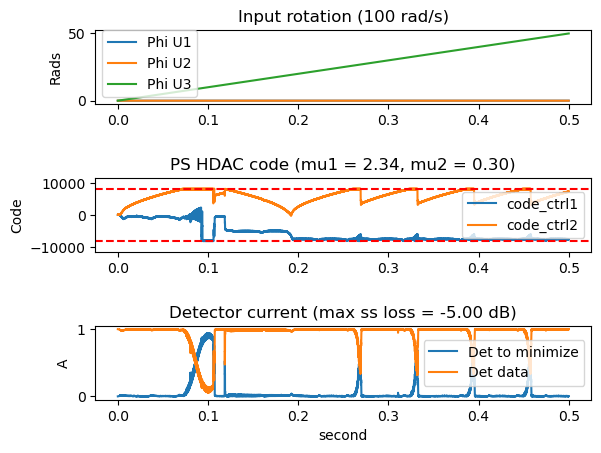

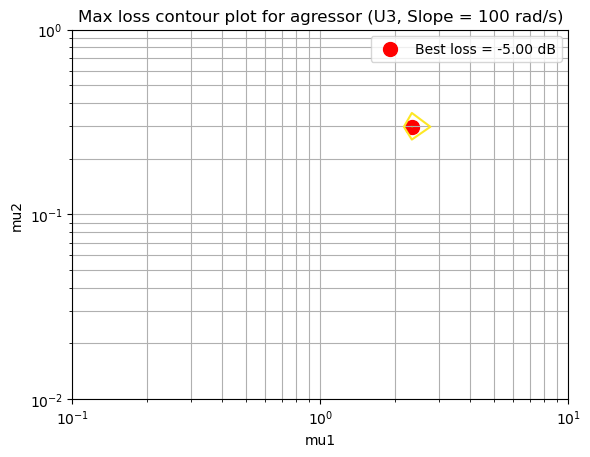

In [8]:
#plotting best case convergence
fig, ax = plt.subplots(3, 1)
ax[0].plot(time, phi_u[0,], label='Phi U1')
ax[0].plot(time, phi_u[1,], label='Phi U2')
ax[0].plot(time, phi_u[2,], label='Phi U3')
ax[0].legend()
ax[0].set_title(f'Input rotation ({slope} rad/s)')
ax[0].set_ylabel('Rads')

ax[1].plot(time, code_ctrl_best[0,], label='code_ctrl1')
ax[1].plot(time, code_ctrl_best[1,], label='code_ctrl2')
ax[1].legend()
ax[1].set_title(f'PS HDAC code (mu1 = {mu1_best:.2f}, mu2 = {mu2_best:.2f})')
ax[1].set_ylabel('Code')
ax[1].set_ylim(-2**(dacres+0.5), 2**(dacres+0.5))
ax[1].axhline(y=2**dacres, color='r', linestyle='--')
ax[1].axhline(y=-2**dacres, color='r', linestyle='--')

ax[2].plot(time, min_det_best, label='Det to minimize')
ax[2].plot(time, max_det_best, label='Det data')
ax[2].legend()
ax[2].set_title(f'Detector current (max ss loss = {max_maxloss:.2f} dB)')
ax[2].set_ylabel('A')
ax[2].set_xlabel('second')
plt.subplots_adjust(hspace=1)  

# plotting contour plot of all maxlosses
mu1_mesh, mu2_mesh = np.meshgrid(mu1_unscaled, mu2_unscaled, indexing='ij')

plt.figure()
contour_levels=[0.1, 0.25, 0.5, 1, 2.5, 5, 10]
contour_plot = plt.contour(mu1_mesh, mu2_mesh, -maxloss, norm=colors.LogNorm(), levels=contour_levels, cmap='viridis')
print(contour_plot.levels)
plt.scatter(mu1_best, mu2_best, color='red', marker='o', s=100, label=f'Best loss = {max_maxloss:.2f} dB')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mu1')
plt.ylabel('mu2')
plt.title(f'Max loss contour plot for agressor (U{u_ind+1}, Slope = {slope} rad/s)')
plt.clabel(contour_plot, inline=True, fontsize=10)
plt.grid(which='both')
plt.show()